In [ ]:
'Author: Srikanth Elkoori Ghantala Karnam'

# Importing Libraries

from math import cos, sin
import numpy as np
#from CartPole import CartPole
from random import random
import scipy.signal as signal
import scipy.linalg as linalg
#from TrajectoryGenerator import TrajectoryGenerator
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import animation

In [ ]:
# Initial Parameters

r0=1500+6378 # distance of sattelite from earth center (km)
G=6.674*10**(-11) # Earth's Gravitational Constant)\
R = 6378/2
k=398600.4418 # G*M (M is the mass of the earth)
w0=np.sqrt(k/r0**3)
m=1000 # mass of the satellite in Kg

# Parameters
r=r0
theta=0.001
phi=0
r_dot=0
theta_dot=w0
phi_dot=0

# Inputs
ur = 0
ut = 0
up = 0

pn = r0 * np.cos(theta)
pe = r0 * np.sin(theta)
pd = r0 * np.sin(phi)

# Initial States
states = np.array([r, theta, phi, r_dot, theta_dot, phi_dot])

# simulation parameters
dt=20
Tfinal=8000
Ts=dt
Tsteps=Tfinal/Ts #framees
frames=int(Tsteps)

In [ ]:
def rotation_matrix_body2Inertial(phi, theta, psi):
    R_b_w=np.array([[cos(theta)*cos(psi), sin(phi)*sin(theta)*cos(psi)-cos(phi)*sin(psi), cos(phi)*sin(theta)*cos(psi)+sin(phi)*sin(psi)],
         [cos(theta)*sin(psi), sin(phi)*sin(theta)*sin(psi)+cos(phi)*cos(psi), cos(phi)*sin(theta)*sin(psi)-sin(phi)*cos(psi)],
         [-sin(theta), sin(phi)*cos(theta), cos(phi)*cos(theta)]])
    return R_b_w

In [ ]:
def sat_dyna(t,y,f):

  r = y[0]
  theta = y[1]
  phi = y[2]
  r_dot = y[3]
  theta_dot = y[4]
  phi_dot = y[5]

  ur = f[0]
  ut = f[1]
  up = f[2]

  ct = np.cos(theta)
  st = np.sin(theta)
  cp = np.cos(phi)
  sp = np.sin(phi)

  r_ddot = (r * theta_dot ** 2 * cp ** 2) + (r * phi_dot ** 2) - (k / r ** 2) + (ur /m)
  theta_ddot = (- 2 * r_dot * theta_dot / r) + (2 * theta_dot * phi_dot * sp / cp) + (ut / m * r * cp)
  phi_ddot = (- theta_dot ** 2 * cp * sp) - (2 * r_dot * phi_dot / r) + (up / m * r)

  return [y[3], y[4], y[5], r_ddot, theta_ddot, phi_ddot]

In [ ]:
def step(states, dt):
  r = states[0]
  theta = states[1]
  phi = states[2]
  r_dot = states[3]
  theta_dot = states[4]
  phi_dot = states[5]

  f = [ 0, 0, 0 ]

  sol = solve_ivp(lambda t , y: sat_dyna(t, y, f), [0, dt], [r, theta, phi, r_dot, theta_dot, phi_dot], t_eval= np.linspace(0, dt, 10))
  states = sol.y[:,-1].T
  return states

Text(0.5, 0.92, 'Satellite-Earth System')

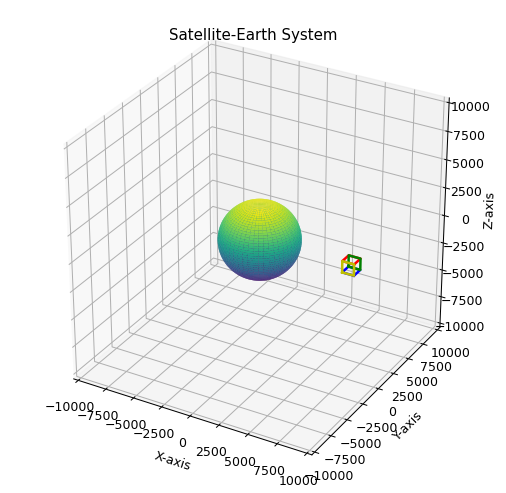

In [ ]:
fig = plt.figure(figsize=(7,7), dpi=90)
ax = fig.add_subplot(1, 1, 1,projection='3d')
ax.set_xlim(( -10000, 10000))            
ax.set_ylim((-10000, 10000))
ax.set_zlim((-10000, 10000))
 
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
 
x = R * np.outer(np.cos(u), np.sin(v))
y = R * np.outer(np.sin(u), np.sin(v))
z = R * np.outer(np.ones(np.size(u)), np.cos(v))
 
ax.plot_surface(x, y, z,  cmap='viridis', edgecolor='none')

phi = 0
theta = 0
psi = 0

sat_x = r*np.cos(theta)
sat_y = r*np.sin(theta)
sat_z = r*sin(phi)

pn = sat_x
pe = sat_y
pd = sat_z

pos=np.array([pn, pe, pd, phi, theta, psi])

w=1000 # width
v1=np.array([w/2, -w/2, -w/2]).T
v2=np.array([-w/2, -w/2, -w/2]).T
v3=np.array([-w/2, w/2, -w/2]).T
v4=np.array([w/2, w/2, -w/2]).T
 
v5=np.array([w/2, -w/2, w/2]).T
v6=np.array([-w/2, -w/2, w/2]).T
v7=np.array([-w/2, w/2, w/2]).T
v8=np.array([w/2, w/2, w/2]).T
 
# inertial coordiantes
N_i=np.array([1, 0, 0]).T
E_i=np.array([0, 1, 0]).T
D_i=np.array([0, 0, 1]).T
 
# Rotate and translate the vertices
pos_ned=np.array([pn, pe, pd]).T
R1=rotation_matrix_body2Inertial(phi,theta,psi)
v1r=np.matmul(R1,v1)+pos_ned
v2r=np.matmul(R1,v2)+pos_ned
v3r=np.matmul(R1,v3)+pos_ned
v4r=np.matmul(R1,v4)+pos_ned
v5r=np.matmul(R1,v5)+pos_ned
v6r=np.matmul(R1,v6)+pos_ned
v7r=np.matmul(R1,v7)+pos_ned
v8r=np.matmul(R1,v8)+pos_ned
# face for 4 cube faces
f1_x=[v1r[0], v2r[0], v3r[0], v4r[0], v1r[0]]
f1_y=[v1r[1], v2r[1], v3r[1], v4r[1], v1r[1]]
f1_z=[v1r[2], v2r[2], v3r[2], v4r[2], v1r[2]]
f2_x=[v5r[0], v6r[0], v7r[0], v8r[0], v5r[0]]
f2_y=[v5r[1], v6r[1], v7r[1], v8r[1], v5r[1]]
f2_z=[v5r[2], v6r[2], v7r[2], v8r[2], v5r[2]]
f3_x=[v3r[0], v4r[0], v8r[0], v7r[0], v3r[0]]
f3_y=[v3r[1], v4r[1], v8r[1], v7r[1], v3r[1]]
f3_z=[v3r[2], v4r[2], v8r[2], v7r[2], v3r[2]]
f4_x=[v2r[0], v1r[0], v5r[0], v6r[0], v2r[0]]
f4_y=[v2r[1], v1r[1], v5r[1], v6r[1], v2r[1]]
f4_z=[v2r[2], v1r[2], v5r[2], v6r[2], v2r[2]]
 
face1, = ax.plot(f1_x, f1_y, f1_z, 'b', lw=2)
face2, = ax.plot(f2_x, f2_y, f2_z, 'r', lw=2)
face3, = ax.plot(f3_x, f3_y, f3_z, 'g', lw=2)
face4, = ax.plot(f4_x, f4_y, f4_z, 'y', lw=2)

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('Satellite-Earth System')

In [ ]:
def satPoints(r,theta,phi):
  sat_x = r*np.cos(theta)
  sat_y = r*np.sin(theta)
  sat_z = r*sin(phi)
  return sat_x, sat_y, sat_z

In [ ]:
# def satPoints(r, theta, phi):
#   R1=rotation_matrix_body2Inertial(phi,theta,psi)
#   v1r=np.matmul(R1,v1)+pos_ned
#   v2r=np.matmul(R1,v2)+pos_ned
#   v3r=np.matmul(R1,v3)+pos_ned
#   v4r=np.matmul(R1,v4)+pos_ned
#   v5r=np.matmul(R1,v5)+pos_ned
#   v6r=np.matmul(R1,v6)+pos_ned
#   v7r=np.matmul(R1,v7)+pos_ned
#   v8r=np.matmul(R1,v8)+pos_ned
#   # face for 4 cube faces
#   f1_x=[v1r[0], v2r[0], v3r[0], v4r[0], v1r[0]]
#   f1_y=[v1r[1], v2r[1], v3r[1], v4r[1], v1r[1]]
#   f1_z=[v1r[2], v2r[2], v3r[2], v4r[2], v1r[2]]
#   f2_x=[v5r[0], v6r[0], v7r[0], v8r[0], v5r[0]]
#   f2_y=[v5r[1], v6r[1], v7r[1], v8r[1], v5r[1]]
#   f2_z=[v5r[2], v6r[2], v7r[2], v8r[2], v5r[2]]
#   f3_x=[v3r[0], v4r[0], v8r[0], v7r[0], v3r[0]]
#   f3_y=[v3r[1], v4r[1], v8r[1], v7r[1], v3r[1]]
#   f3_z=[v3r[2], v4r[2], v8r[2], v7r[2], v3r[2]]
#   f4_x=[v2r[0], v1r[0], v5r[0], v6r[0], v2r[0]]
#   f4_y=[v2r[1], v1r[1], v5r[1], v6r[1], v2r[1]]
#   f4_z=[v2r[2], v1r[2], v5r[2], v6r[2], v2r[2]]

#   return f1_x, f1_y, f1_z, f2_x, f2_y, f2_z, f3_x, f3_y, f3_z, f4_x, f4_y, f4_z

In [ ]:
def drawframe(i):
  global states
  states = step(states, dt)
  r = states[0]
  theta = states[1]
  phi = states[2]

  sat_x, sat_y, sat_z = satPoints(r, theta, phi)
  pn = sat_x
  pe = sat_y
  pd = sat_z

  phi = pos[3]
  theta = pos[4]
  psi = pos[5]

  pos_ned = np.array([pn, pe, pd]).T

  R1=rotation_matrix_body2Inertial(phi,theta,psi)
  v1r=np.matmul(R1,v1)+pos_ned
  v2r=np.matmul(R1,v2)+pos_ned
  v3r=np.matmul(R1,v3)+pos_ned
  v4r=np.matmul(R1,v4)+pos_ned
  v5r=np.matmul(R1,v5)+pos_ned
  v6r=np.matmul(R1,v6)+pos_ned
  v7r=np.matmul(R1,v7)+pos_ned
  v8r=np.matmul(R1,v8)+pos_ned
  # face for 4 cube faces
  f1_x=[v1r[0], v2r[0], v3r[0], v4r[0], v1r[0]]
  f1_y=[v1r[1], v2r[1], v3r[1], v4r[1], v1r[1]]
  f1_z=[v1r[2], v2r[2], v3r[2], v4r[2], v1r[2]]
  f2_x=[v5r[0], v6r[0], v7r[0], v8r[0], v5r[0]]
  f2_y=[v5r[1], v6r[1], v7r[1], v8r[1], v5r[1]]
  f2_z=[v5r[2], v6r[2], v7r[2], v8r[2], v5r[2]]
  f3_x=[v3r[0], v4r[0], v8r[0], v7r[0], v3r[0]]
  f3_y=[v3r[1], v4r[1], v8r[1], v7r[1], v3r[1]]
  f3_z=[v3r[2], v4r[2], v8r[2], v7r[2], v3r[2]]
  f4_x=[v2r[0], v1r[0], v5r[0], v6r[0], v2r[0]]
  f4_y=[v2r[1], v1r[1], v5r[1], v6r[1], v2r[1]]
  f4_z=[v2r[2], v1r[2], v5r[2], v6r[2], v2r[2]]
  

  face1.set_data(f1_x, f1_y)
  face1.set_3d_properties(f1_z)
  face2.set_data(f2_x, f2_y)
  face2.set_3d_properties(f2_z)
  face3.set_data(f3_x, f3_y)
  face3.set_3d_properties(f3_z)
  face4.set_data(f4_x, f4_y)
  face4.set_3d_properties(f3_z)

  return face1, face2, face3, face4


In [ ]:
from matplotlib import animation
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('Satellite-Earth System')
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=frames, interval=40, blit=True)

In [ ]:
from IPython.display import HTML
HTML(anim.to_html5_video())

Using the given conditions as the initial inputs we see in the above animation the satellite will move in a circular orbit.

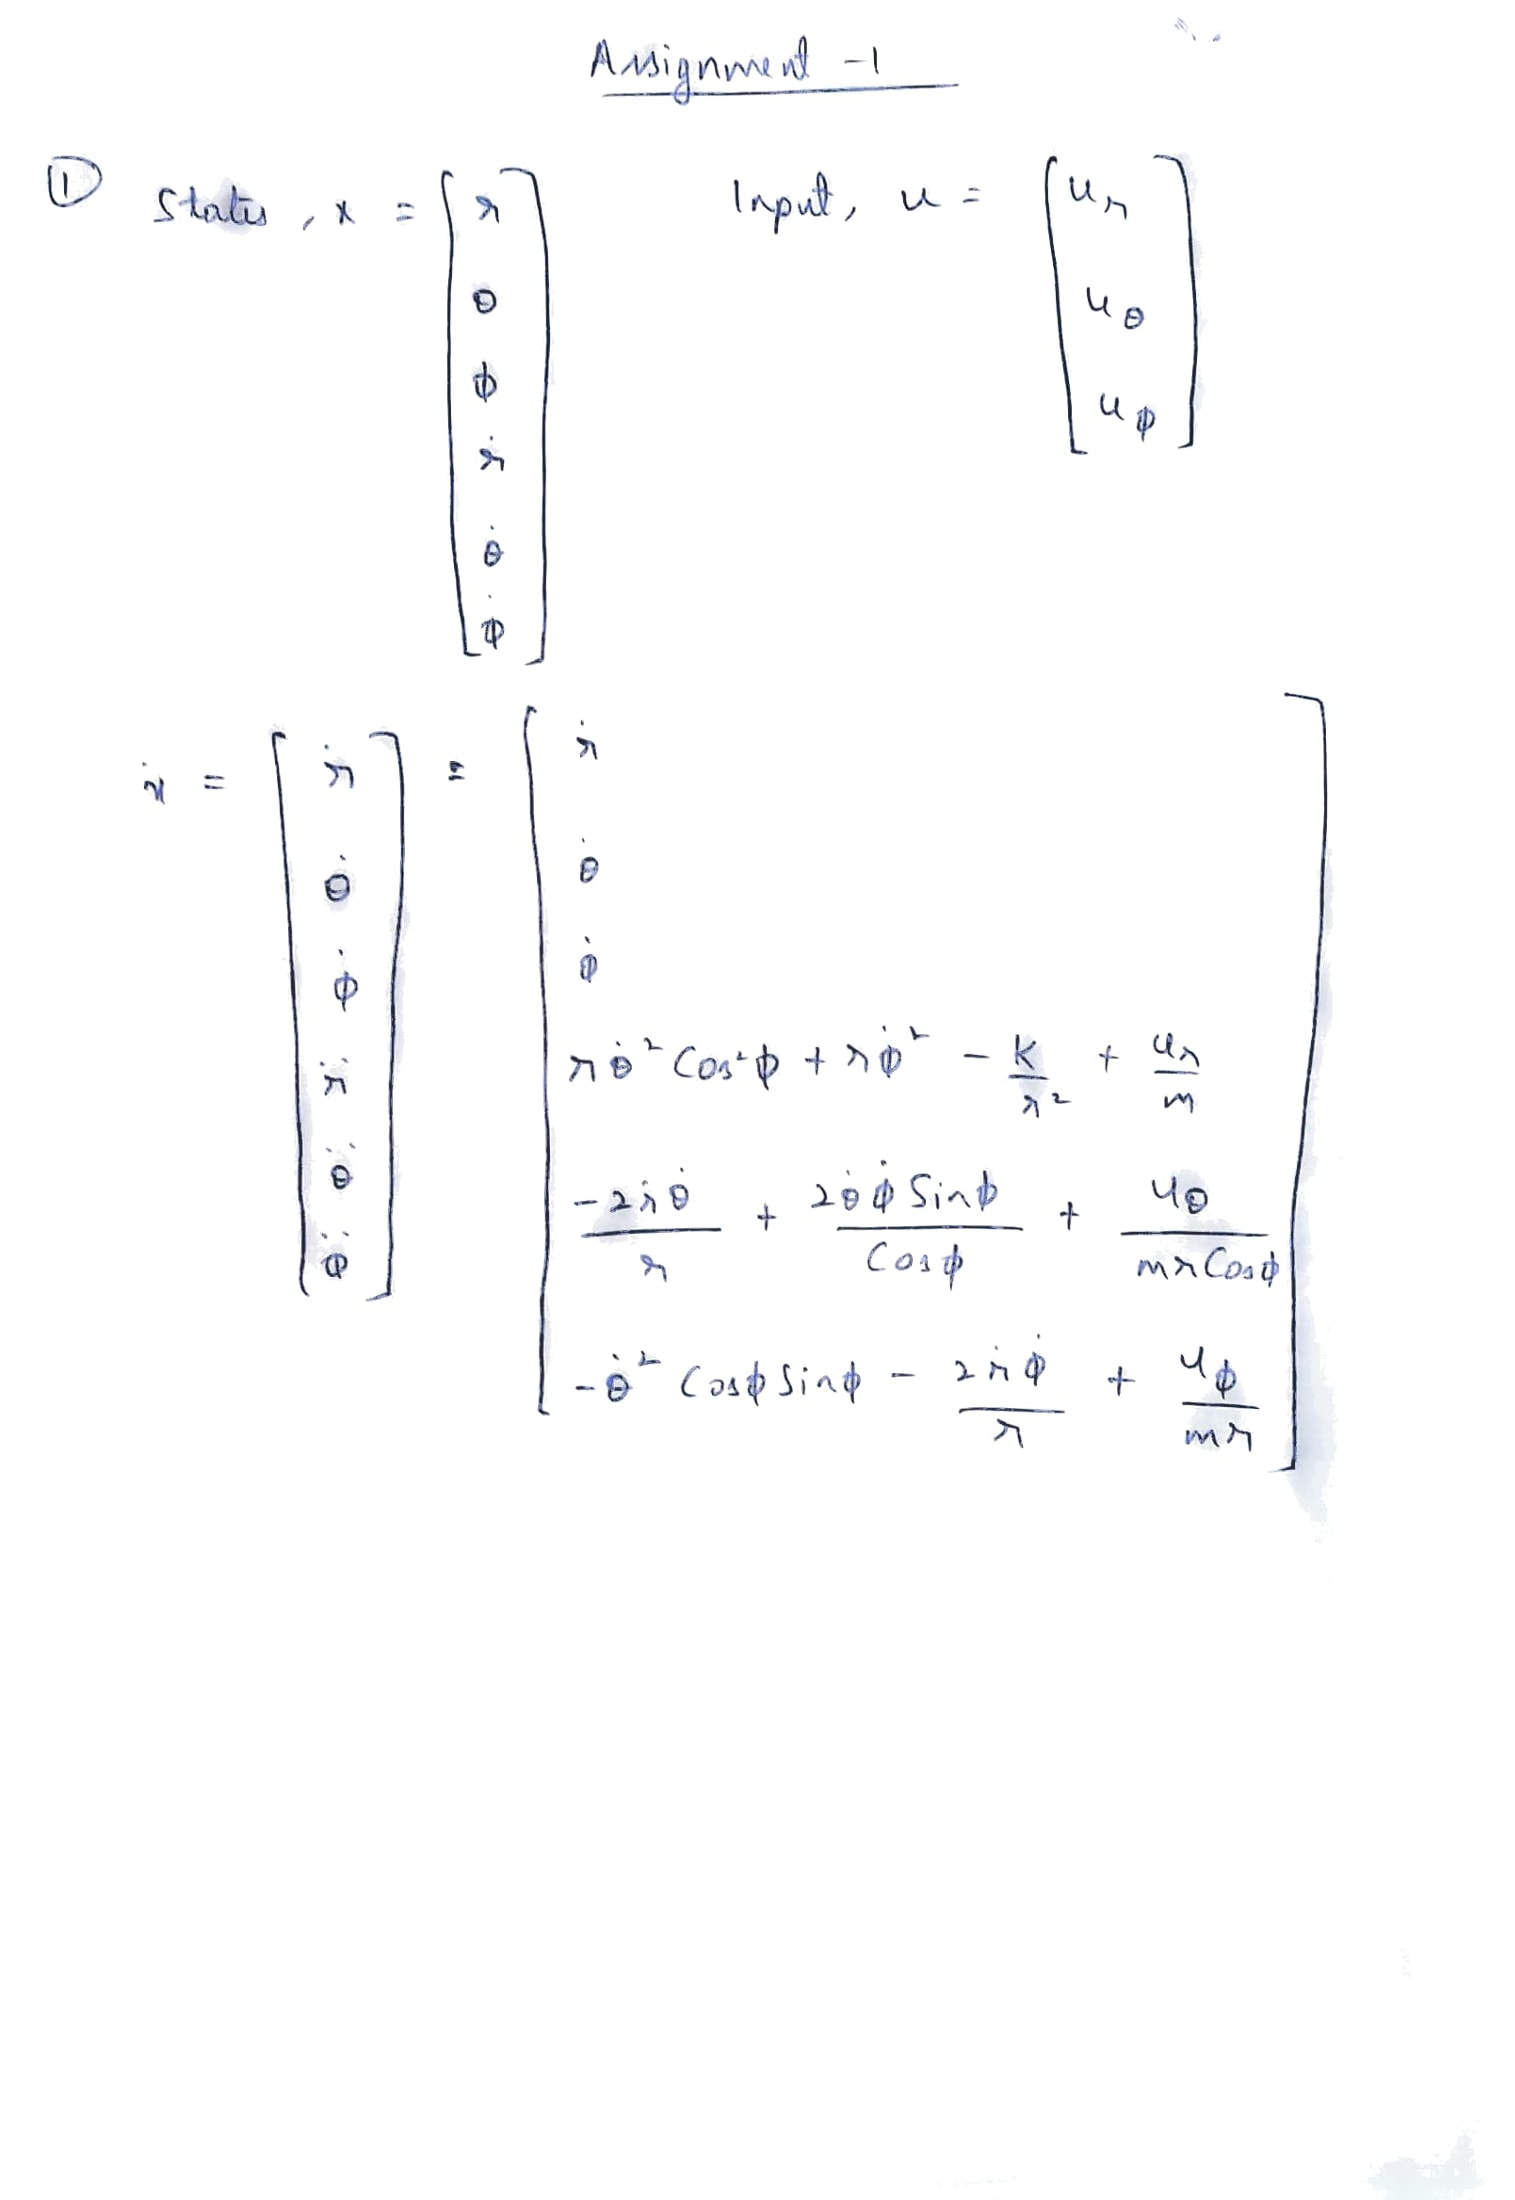